# Wspd Arima

https://leedakyeong.tistory.com/entry/Python-%EB%82%A0%EC%94%A8-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0Kaggle%EB%A1%9C-ARIMA-%EC%A0%81%EC%9A%A9%ED%95%98%EA%B8%B0

참조

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima.model import ARIMA

In [3]:
plt.style.use('ggplot')

In [4]:
train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [5]:
# train_data의 결측값 확인
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64

In [6]:
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# 결측값 처리
train_data = train_data.fillna(method = 'ffill').fillna(method = 'bfill')

print(train_data.isnull().sum())

TurbID     0
Day        0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64


In [7]:
train_data = train_data[train_data['TurbID']==21]

In [8]:
train_data = train_data[['Day','Tmstamp','Patv','Wspd']]

In [9]:
train_data.head()

,Day,Tmstamp,Patv,Wspd
576000,1,00:00,157.50,3.07
576001,1,00:10,293.28,5.46
576002,1,00:20,268.40,5.11
576003,1,00:30,252.73,4.80
576004,1,00:40,253.02,4.74


In [10]:
train_data.shape

(28800, 4)

In [11]:
train_data

,Day,Tmstamp,Patv,Wspd
576000,1,00:00,157.50,3.07
576001,1,00:10,293.28,5.46
576002,1,00:20,268.40,5.11
576003,1,00:30,252.73,4.80
576004,1,00:40,253.02,4.74
...,...,...,...,...
604795,200,23:10,200.87,4.05
604796,200,23:20,278.29,4.66
604797,200,23:30,219.26,4.26
604798,200,23:40,140.48,3.32


In [12]:
from datetime import datetime
from datetime import timedelta
dt = datetime(2020, 12, 31,23,50)
Days= []
for i in range(28800): 
    dt = dt + timedelta(minutes=10)
    dd=dt.strftime("%Y-%m-%d %H:%M")
    Days.append(dd)

In [13]:
train_data['Day']=Days

In [14]:
train_data.columns=['ds',"Tmstamp","Patv","Wspd"]

In [15]:
train_data

,ds,Tmstamp,Patv,Wspd
576000,2021-01-01 00:00,00:00,157.50,3.07
576001,2021-01-01 00:10,00:10,293.28,5.46
576002,2021-01-01 00:20,00:20,268.40,5.11
576003,2021-01-01 00:30,00:30,252.73,4.80
576004,2021-01-01 00:40,00:40,253.02,4.74
...,...,...,...,...
604795,2021-07-19 23:10,23:10,200.87,4.05
604796,2021-07-19 23:20,23:20,278.29,4.66
604797,2021-07-19 23:30,23:30,219.26,4.26
604798,2021-07-19 23:40,23:40,140.48,3.32


In [16]:
train_data['ds']=pd.to_datetime(train_data['ds'])

In [17]:
train_data.index = train_data.ds

In [18]:
train_data.drop(['Tmstamp','ds'],axis=1,inplace=True)

In [19]:
train_data.head()

,Patv,Wspd
ds,,
2021-01-01 00:00:00,157.50,3.07
2021-01-01 00:10:00,293.28,5.46
2021-01-01 00:20:00,268.40,5.11
2021-01-01 00:30:00,252.73,4.80
2021-01-01 00:40:00,253.02,4.74


In [20]:
train_data.tail()

,Patv,Wspd
ds,,
2021-07-19 23:10:00,200.87,4.05
2021-07-19 23:20:00,278.29,4.66
2021-07-19 23:30:00,219.26,4.26
2021-07-19 23:40:00,140.48,3.32
2021-07-19 23:50:00,142.61,3.22


# 시계열 분해

In [21]:
train_data.index

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 00:10:00',
               '2021-01-01 00:20:00', '2021-01-01 00:30:00',
               '2021-01-01 00:40:00', '2021-01-01 00:50:00',
               '2021-01-01 01:00:00', '2021-01-01 01:10:00',
               '2021-01-01 01:20:00', '2021-01-01 01:30:00',
               ...
               '2021-07-19 22:20:00', '2021-07-19 22:30:00',
               '2021-07-19 22:40:00', '2021-07-19 22:50:00',
               '2021-07-19 23:00:00', '2021-07-19 23:10:00',
               '2021-07-19 23:20:00', '2021-07-19 23:30:00',
               '2021-07-19 23:40:00', '2021-07-19 23:50:00'],
              dtype='datetime64[ns]', name='ds', length=28800, freq=None)

In [22]:
train_data[-2880:]

,Patv,Wspd
ds,,
2021-06-30 00:00:00,0.00,1.57
2021-06-30 00:10:00,0.00,1.54
2021-06-30 00:20:00,0.00,1.53
2021-06-30 00:30:00,0.00,1.90
2021-06-30 00:40:00,0.00,2.37
...,...,...
2021-07-19 23:10:00,200.87,4.05
2021-07-19 23:20:00,278.29,4.66
2021-07-19 23:30:00,219.26,4.26


Text(0, 0.5, 'Wspd')

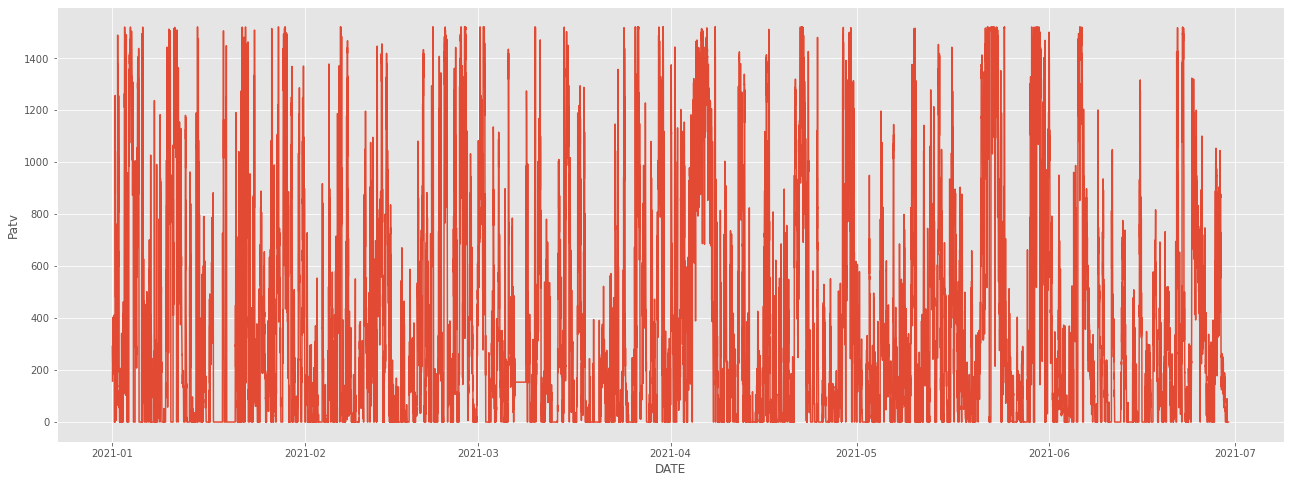

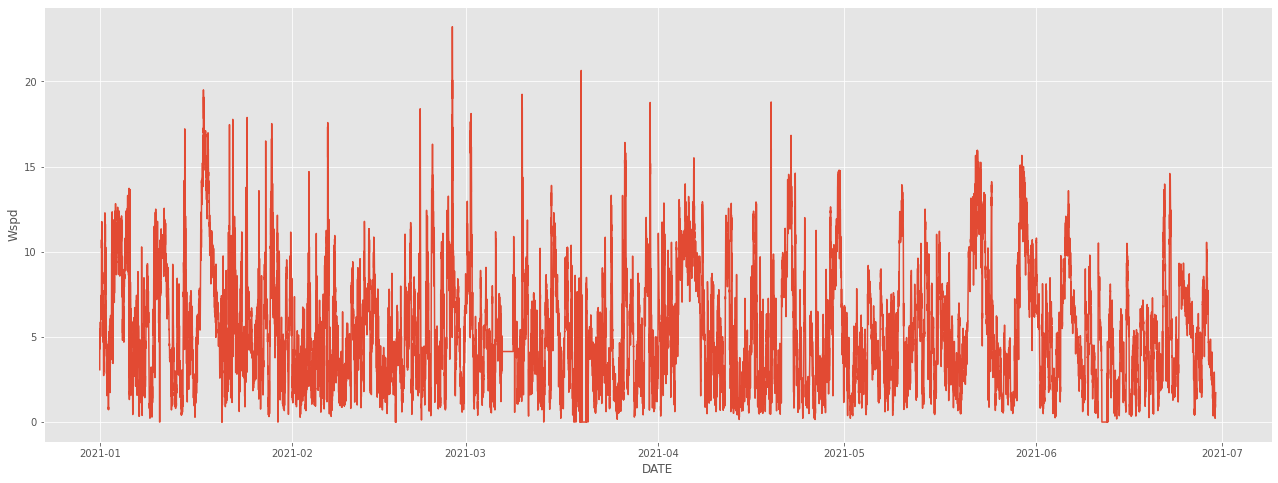

In [23]:
plt.figure(figsize=(22,8))
plt.plot(train_data[:-2880].index, train_data[:-2880].Patv)
plt.xlabel("DATE")
plt.ylabel("Patv")

plt.figure(figsize=(22,8))
plt.plot(train_data[:-2880].index, train_data[:-2880].Wspd)
plt.xlabel("DATE")
plt.ylabel("Wspd")

#for i in np.arange(0,28800,288):
#    plt.vlines(train_data.index[i], 0, 20, color='gray', linestyle='solid', linewidth=3)


Text(0, 0.5, 'Wspd')

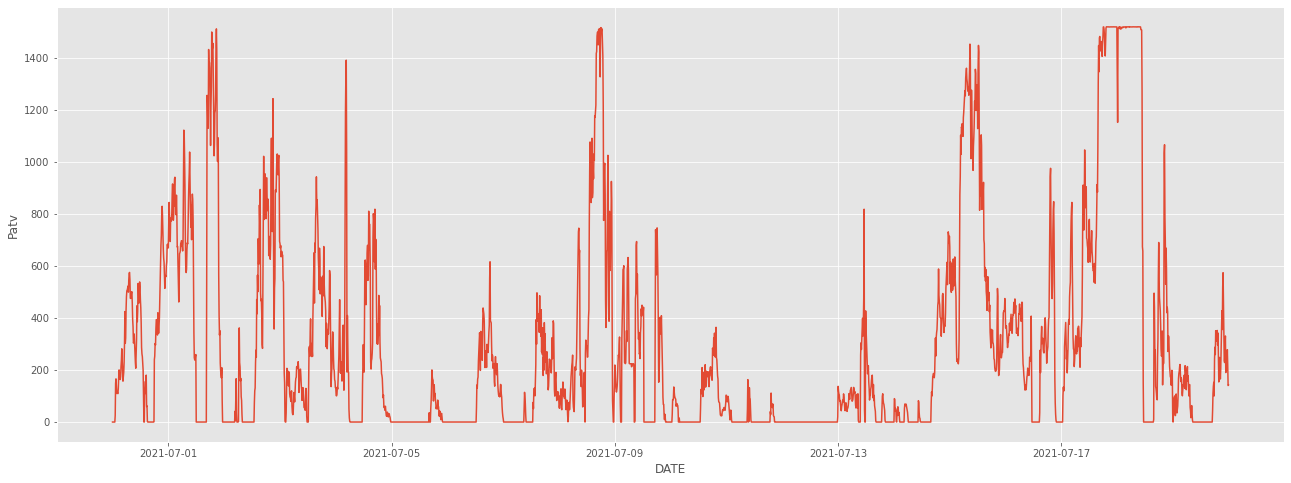

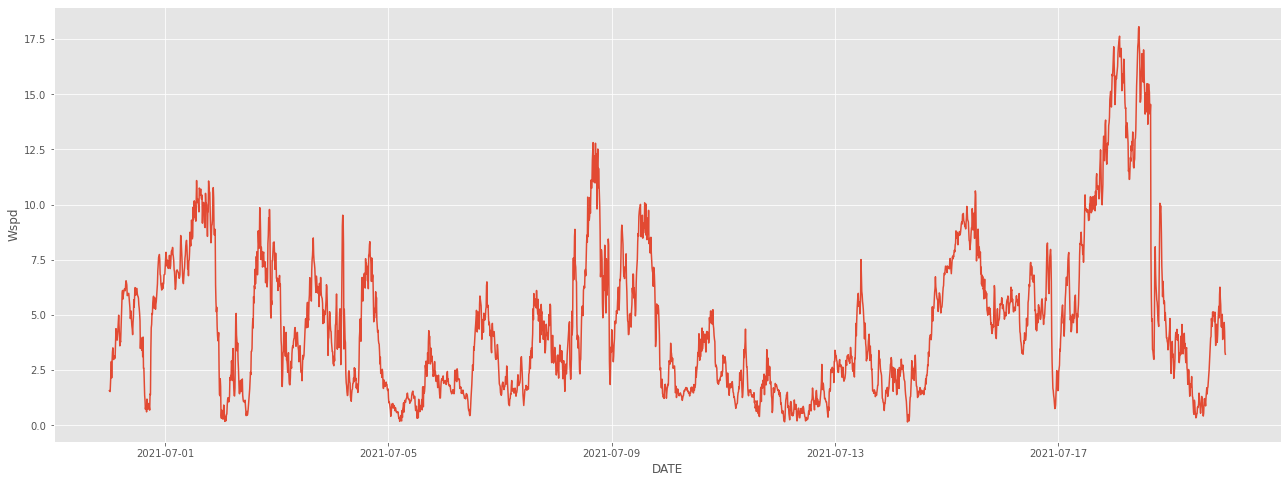

In [24]:
lookat = -288*10
plt.figure(figsize=(22,8))
plt.plot(train_data[lookat:].index, train_data[lookat:].Patv)
plt.xlabel("DATE")
plt.ylabel("Patv")

plt.figure(figsize=(22,8))
plt.plot(train_data[lookat:].index, train_data[lookat:].Wspd)
plt.xlabel("DATE")
plt.ylabel("Wspd")


#for i in np.arange(0,28800,288):
#    plt.vlines(train_data.index[i], 0, 20, color='gray', linestyle='solid', linewidth=3)


분산이 큰 비정상 시계열이라 할 수 있다.



<Figure size 432x288 with 0 Axes>

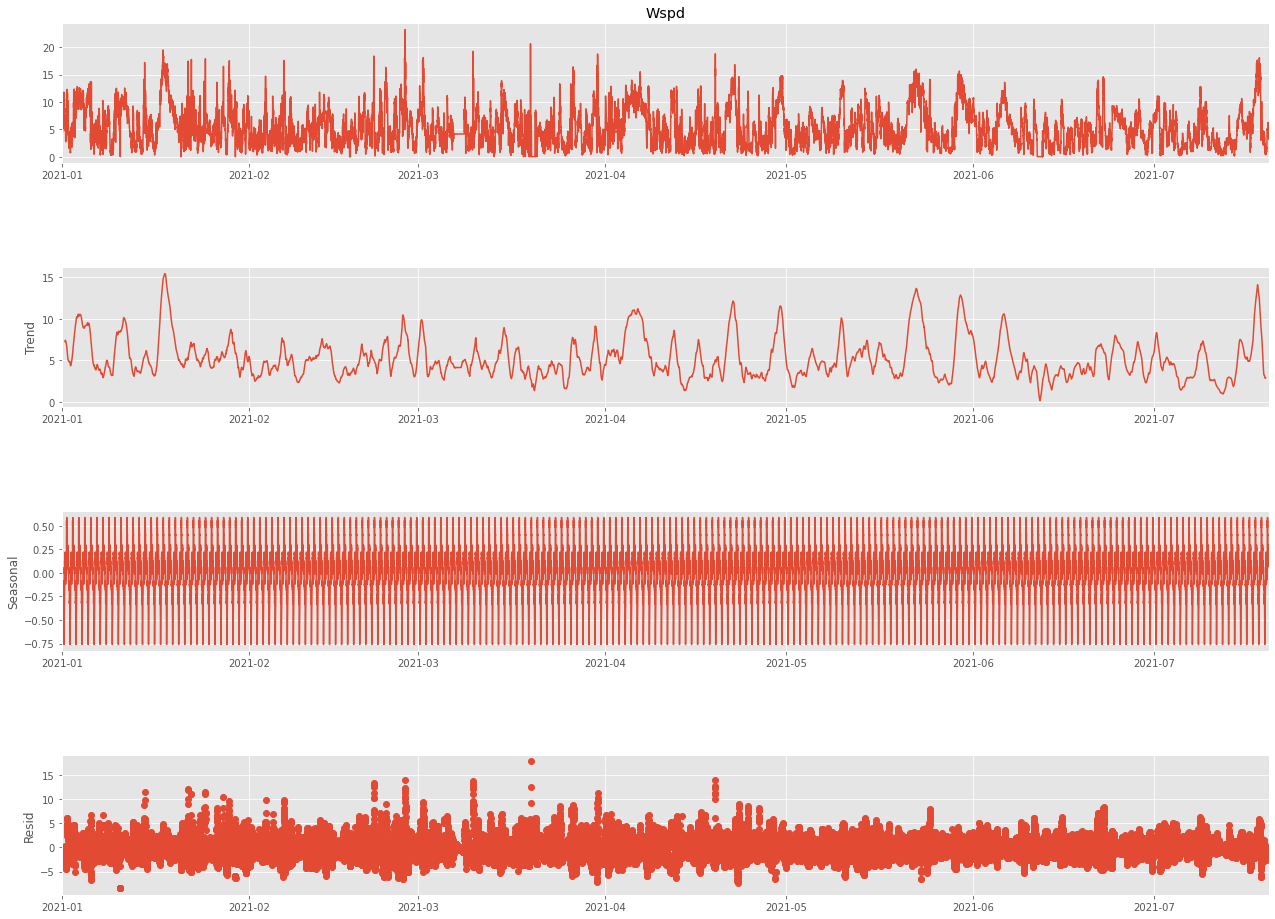

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_data.Wspd,model='additive',period=144)


fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

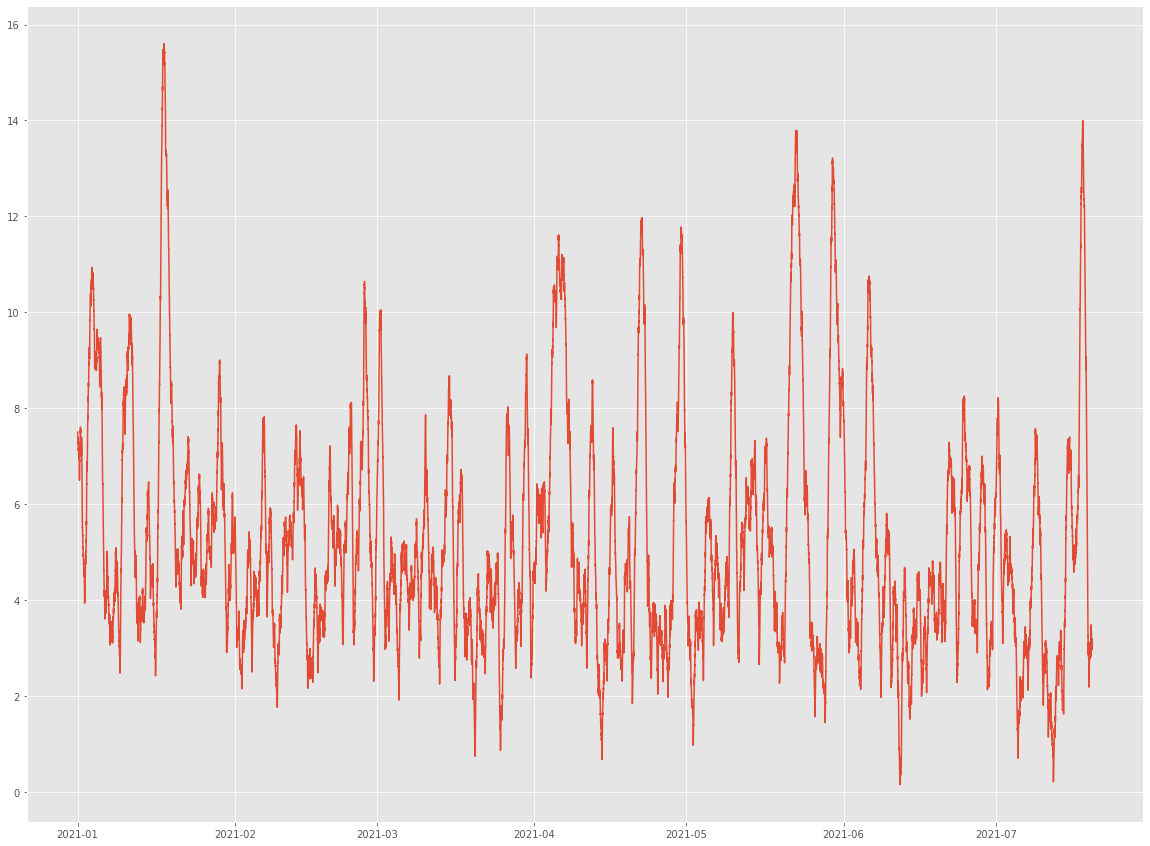

In [26]:
fig = plt.figure()
fig.set_size_inches(20,15)
fig= plt.plot(result.trend.fillna(method='bfill').fillna(method='ffill')+result.seasonal)

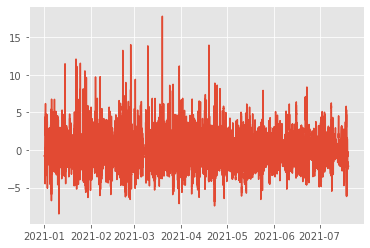

In [27]:
plt.plot(result.resid.fillna(method='bfill').fillna(method='ffill'))

Text(0, 0.5, 'Wspd')

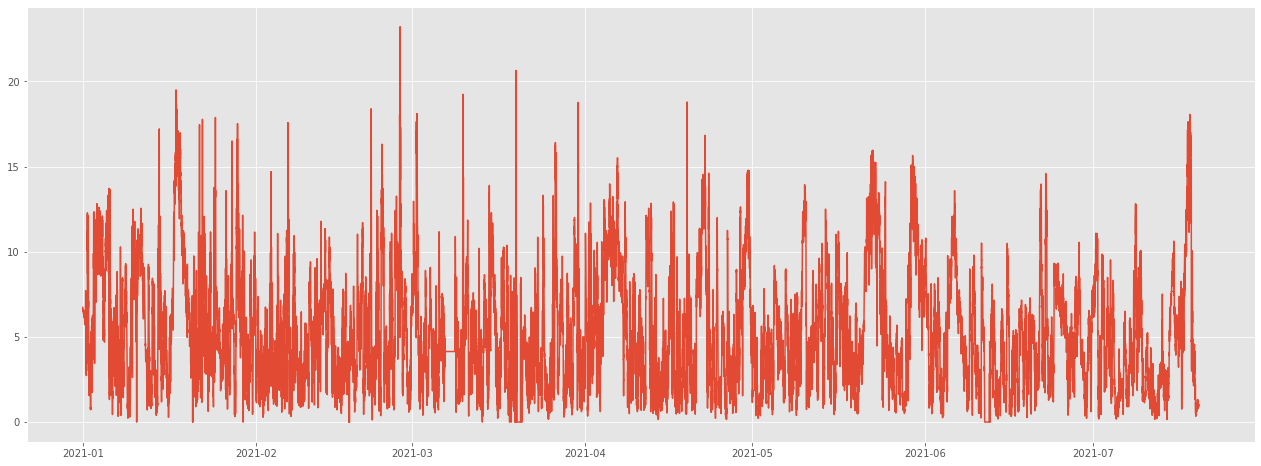

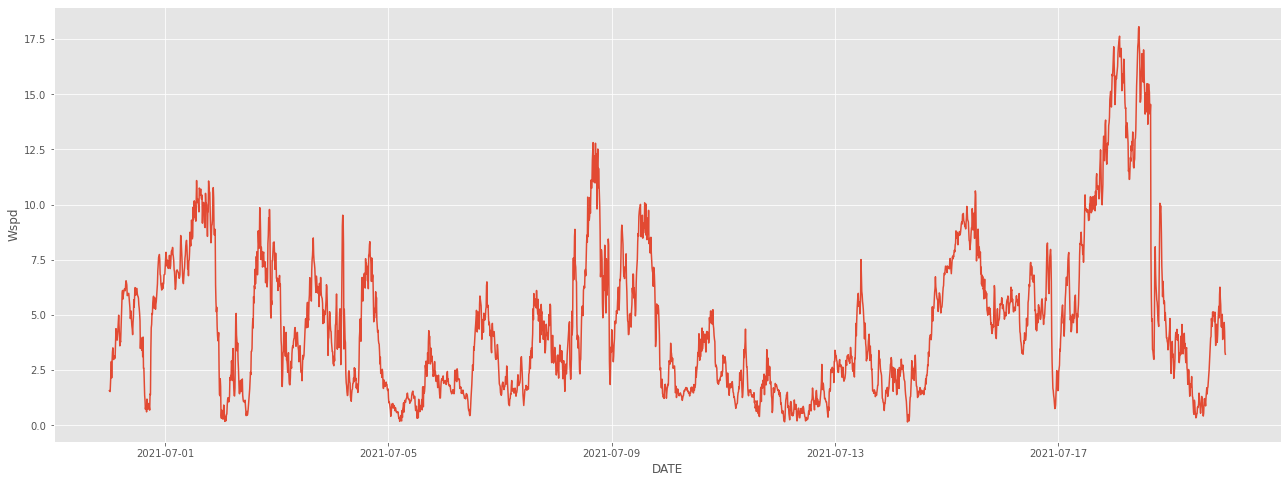

In [28]:
fig = plt.figure()
fig.set_size_inches(22,8)
fig= plt.plot(result.trend.fillna(method='bfill').fillna(method='ffill') + result.seasonal+ 
             result.resid.fillna(method='bfill').fillna(method='ffill'))

plt.figure(figsize=(22,8))
plt.plot(train_data[lookat:].index, train_data[lookat:].Wspd)
plt.xlabel("DATE")
plt.ylabel("Wspd")

# acf, pacf

비정상성을 제거하는 모델 ARIMA

- p : AR이 몇번째 까지 과거를 보는지
- d : 차분에 대한 파라미터
- q:  MR이 몇번째 과거까지 보는지


https://hongl.tistory.com/98

https://happy-chipmunk.tistory.com/entry/%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%B6%84%EC%84%9D-%EB%8D%B0%EC%9D%B4%ED%84%B0-Stationarity-check-%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%9C%BC%EB%A1%9C-%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%9D%98-%EA%B3%84%EC%A0%88%EC%84%B1%EC%A3%BC%EA%B8%B0%EC%84%B1-%ED%8C%8C%EC%95%85%ED%95%98%EA%B8%B0-1-ACF-PACF-%ED%94%8C%EB%A1%AF-%EA%B7%B8%EB%A6%AC%EA%B3%A0-%ED%95%B4%EC%84%9D%ED%95%98%EA%B8%B0

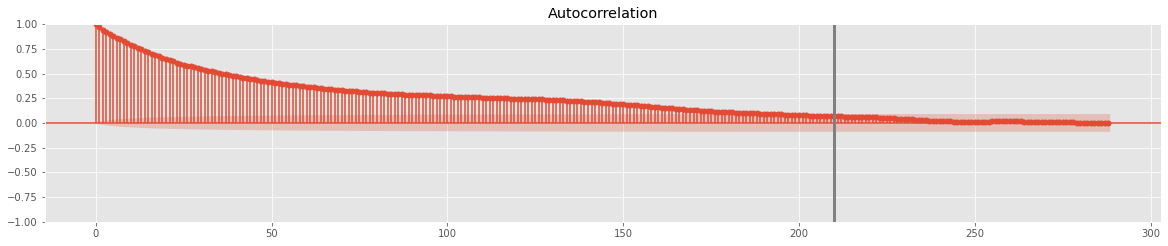

In [29]:

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_data['Wspd'],lags=288,ax=ax1)
plt.vlines(210, -1.0, 1.0, color='gray', linestyle='solid', linewidth=3)


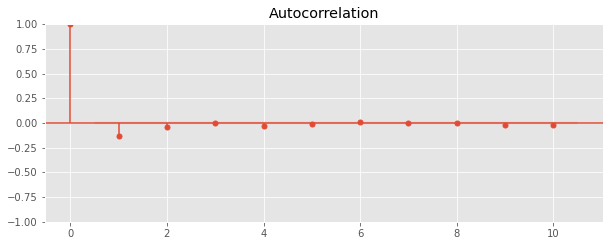

In [30]:
ts=train_data['Wspd']-train_data['Wspd'].shift().fillna(method="bfill")


fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(ts,lags=10,ax=ax1)
#plt.vlines(210, -1.0, 1.0, color='gray', linestyle='solid', linewidth=3)


Text(0, 0.5, 'Wspd')

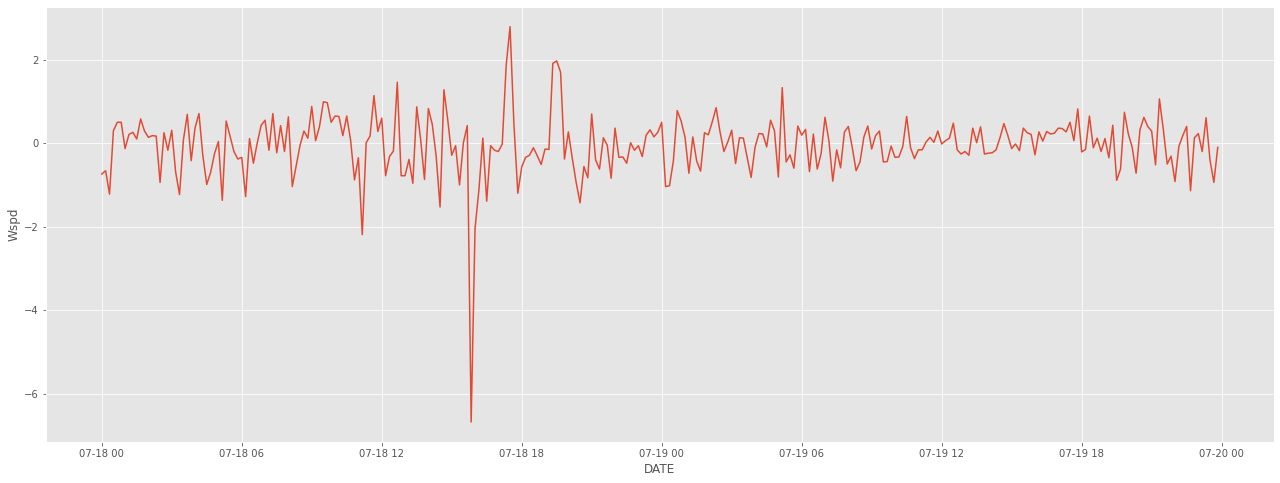

In [31]:
lookat = -288

plt.figure(figsize=(22,8))
plt.plot(ts[lookat:].index, ts[lookat:])

plt.xlabel("DATE")
plt.ylabel("Wspd")


#for i in np.arange(0,28800,288):
#    plt.vlines(train_data.index[i], 0, 20, color='gray', linestyle='solid', linewidth=3)


<Figure size 432x288 with 0 Axes>

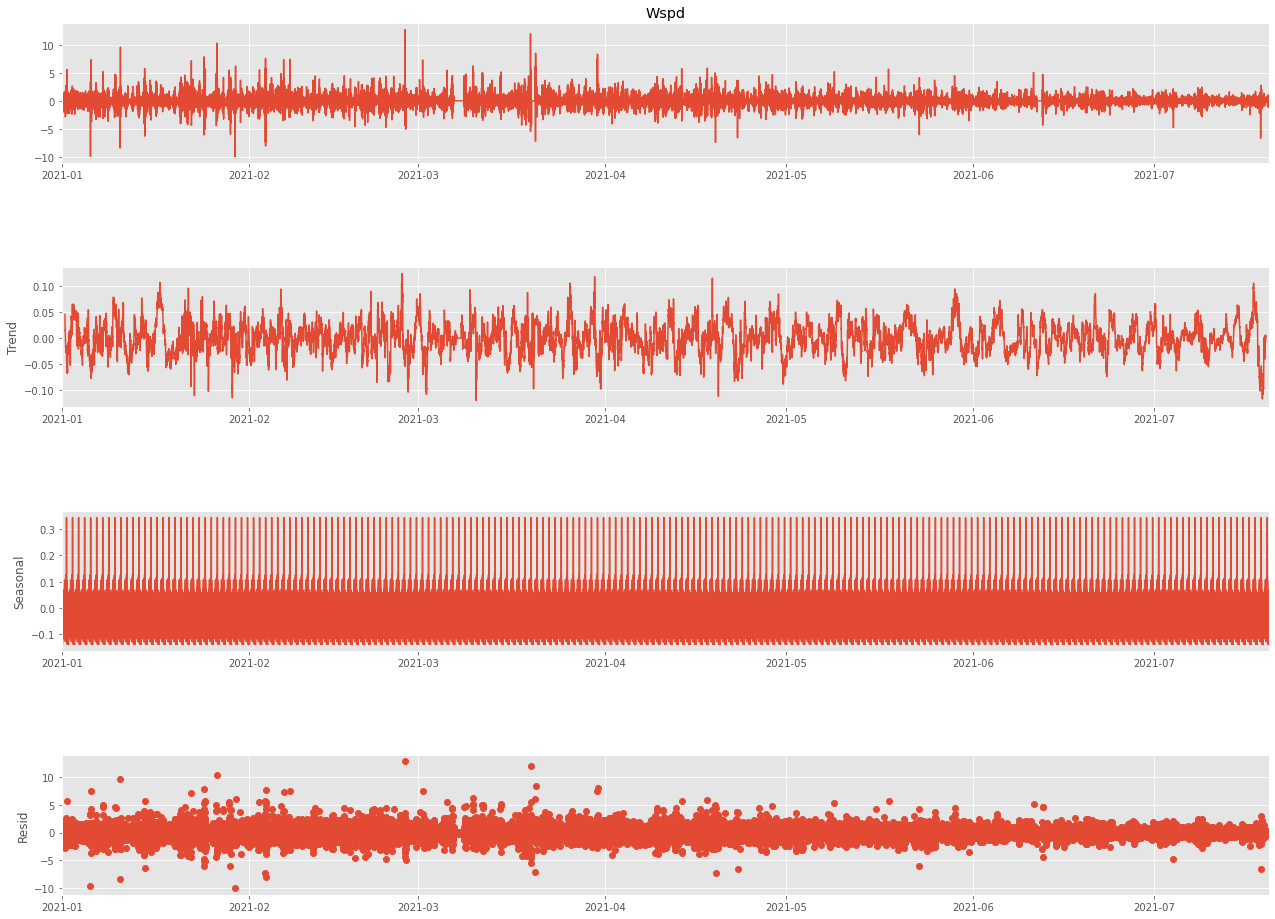

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts,model='additive',period=144)


fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

0보다 크게 떨어지니, 정상성 만족 x.  데이터에 패턴이 존재한다고 할 수 있다.

모든 데이터가 자기 상관성을 띈다고 보인다.

In [39]:
result = adfuller(train_data['Wspd'],autolag=None,maxlag=144*2)
print("ADF Statistics : {}".format(result[0]))
print("p-value : {}".format(result[1]))



ADF Statistics : -8.185642716760084
p-value : 7.913460017477318e-13


In [33]:
result = adfuller(ts,autolag=None,maxlag=144*2)
print("ADF Statistics : {}".format(result[0]))
print("p-value : {}".format(result[1]))



ADF Statistics : -13.906085209900667
p-value : 5.619678554382345e-26


ADF TEST는 통과한다. 
하지만, 0으로 수렴하는 과정이 매우 느리다.

In [40]:
def kpss_test(df):
    statistic, p_value,n_lags, critical_values = kpss(df)
    
    print("KPSS Statistic : {}".format(statistic))
    print("p-value : {}".format(p_value))
    print("num lags : {}".format(n_lags))
kpss_test(train_data['Wspd'])


KPSS Statistic : 0.12535050100482364
p-value : 0.1
num lags : 95


C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


kpss test 귀무가설을 기각하지 못하니, 안정적이라 할 수 있지만.

거의 0.05에 가깝다.

로그 변환은 하지 않는것이 좋다.

In [41]:
kpss_test(train_data['Wspd'])

KPSS Statistic : 0.12535050100482364
p-value : 0.1
num lags : 95


C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


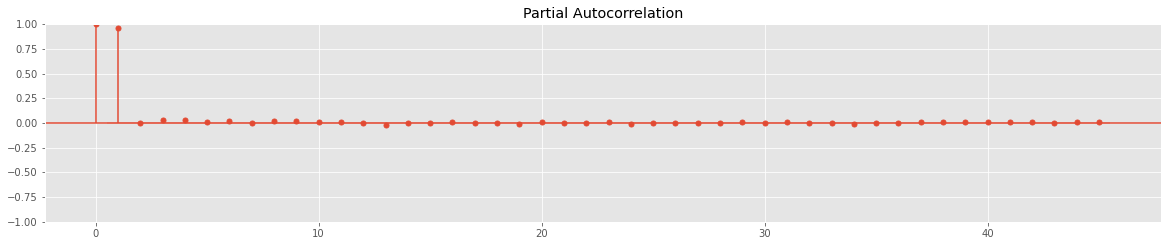

In [42]:

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(train_data['Wspd'],ax=ax1)

P=2

현재는 AR(2) 모델이 가장 적합할 것으로 보인다.

# ARIMA

In [62]:
train_data_reduced = train_data.copy()

In [63]:
train_data_reduced=train_data_reduced.iloc[:-288,:]

In [64]:
model = ARIMA(train_data_reduced['Wspd'],order=(2,1,1),freq='10T')
model_fit = model.fit()

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


In [65]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Wspd   No. Observations:                28512
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -36000.683
Date:                Thu, 21 Jul 2022   AIC                          72009.366
Time:                        18:18:51   BIC                          72042.398
Sample:                    01-01-2021   HQIC                         72019.990
                         - 07-17-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8528      0.003    284.696      0.000       0.847       0.859
ar.L2          0.1176      0.003     38.313      0.000       0.112       0.124
ma.L1         -0.9996      0.000  -5129.576      0.0

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50676 (\N{HANGUL SYLLABLE YEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from c

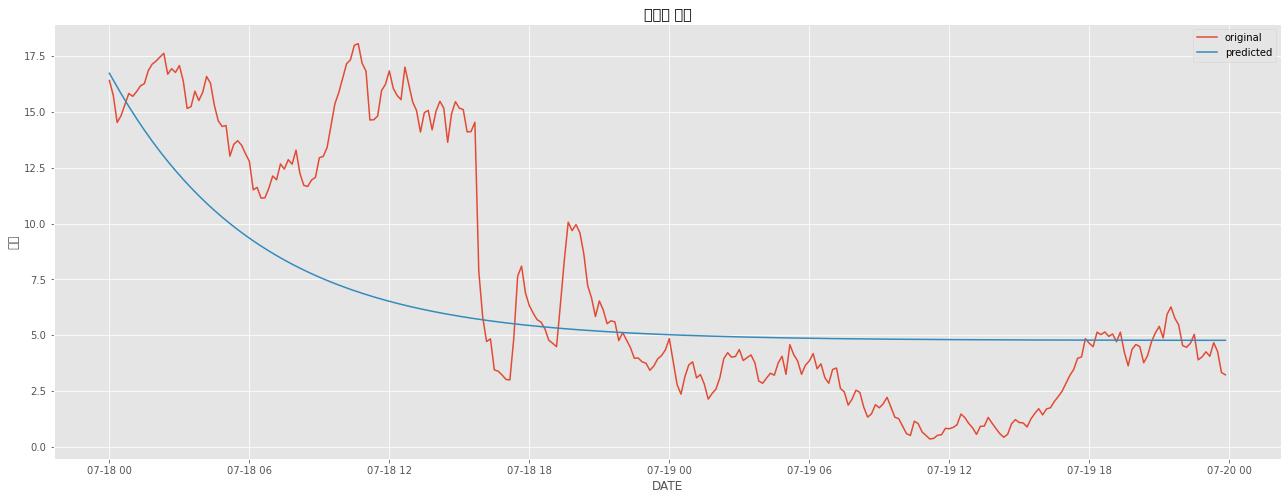

In [66]:
start_index=datetime(2021,7,18,0,0)
end_index=datetime(2021,7,19,23,50)
forecast = model_fit.predict(start=start_index,end=end_index,type='levels')

#시각화
plt.figure(figsize=(22,8))
plt.plot(train_data.loc[start_index:].index,train_data.loc[start_index:].Wspd,label="original")
plt.plot(forecast,label='predicted')
plt.title("시계열 예측")
plt.xlabel("DATE")
plt.ylabel("풍속")
plt.legend()
plt.show()





In [48]:
forecast

2021-07-18 00:00:00    1478.393639
2021-07-18 00:10:00    1438.829134
2021-07-18 00:20:00    1400.661421
2021-07-18 00:30:00    1363.842007
2021-07-18 00:40:00    1328.323259
                          ...     
2021-07-19 23:10:00     358.414742
2021-07-19 23:20:00     358.413238
2021-07-19 23:30:00     358.411788
2021-07-19 23:40:00     358.410389
2021-07-19 23:50:00     358.409039
Freq: 10T, Name: predicted_mean, Length: 288, dtype: float64

In [22]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

from tqdm import tqdm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima.model import ARIMA


from datetime import datetime
from datetime import timedelta

train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")
train_data = train_data[['TurbID','Day','Tmstamp','Patv']]

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
train_data.iloc[9583:]

,TurbID,Day,Tmstamp,Patv
9583,1,67,13:10,NaN
9584,1,67,13:20,NaN
9585,1,67,13:30,1416.35
9586,1,67,13:40,1423.96
9587,1,67,13:50,1451.06
...,...,...,...,...
3859195,134,200,23:10,308.65
3859196,134,200,23:20,221.60
3859197,134,200,23:30,220.60
3859198,134,200,23:40,222.15


In [15]:
tmp = train_data[train_data["TurbID"] == 1]
tmp.reset_index(inplace=True)

tmp[28800-288*2:]

,index,TurbID,Day,Tmstamp,Patv
28224,28224,1,197,00:00,995.55
28225,28225,1,197,00:10,823.07
28226,28226,1,197,00:20,860.06
28227,28227,1,197,00:30,774.70
28228,28228,1,197,00:40,704.02
...,...,...,...,...,...
28795,28795,1,200,23:10,296.34
28796,28796,1,200,23:20,178.46
28797,28797,1,200,23:30,164.19
28798,28798,1,200,23:40,259.42


In [24]:
tmp = train_data[train_data["TurbID"] == 1]
tmp.reset_index(inplace=True)
tmp = tmp.iloc[9585:]
tmp.reset_index(inplace=True)
#tmp=tmp[28800-288*5:]
tmp=tmp.fillna(method = 'ffill').fillna(method = 'bfill')
tmp

,level_0,index,TurbID,Day,Tmstamp,Patv
0,9585,9585,1,67,13:30,1416.35
1,9586,9586,1,67,13:40,1423.96
2,9587,9587,1,67,13:50,1451.06
3,9588,9588,1,67,14:00,1256.14
4,9589,9589,1,67,14:10,1375.47
...,...,...,...,...,...,...
19210,28795,28795,1,200,23:10,296.34
19211,28796,28796,1,200,23:20,178.46
19212,28797,28797,1,200,23:30,164.19
19213,28798,28798,1,200,23:40,259.42


In [25]:
answers= [ ]
for i in tqdm(range(1,135)):
    tmp = train_data[train_data["TurbID"] == i]
    tmp.reset_index(inplace=True)
    tmp = tmp.iloc[9585:]
    tmp.reset_index(inplace=True)
    tmp=tmp.fillna(method = 'ffill').fillna(method = 'bfill')
    
    model = ARIMA(tmp['Patv'],order=(2,0,0))
    model_fit = model.fit()
    start_index=19215
    end_index=19215+288-1
    forecast = model_fit.predict(start=start_index,end=end_index,type='levels')
    answers.append(forecast)


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [01:15<00:00,  1.79it/s]


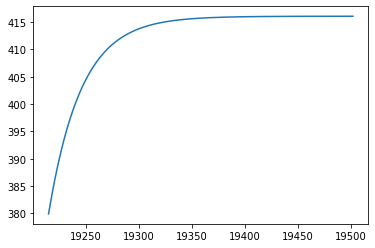

In [29]:
plt.plot(answers[11])

In [65]:
from datetime import datetime
from datetime import timedelta

train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")
train_data = train_data[['TurbID','Day','Tmstamp','Patv']]
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# 결측값 처리
train_data = train_data.fillna(method = 'ffill').fillna(method = 'bfill')

print(train_data.isnull().sum())

answers= [ ]

for i in range(1,135):
    train_data_reduced = train_data.copy()
    train_data_reduced = train_data_reduced[train_data_reduced['TurbID']==i]
    dt = datetime(2020, 12, 31,23,50)
    Days= []
    for i in range(28800): 
        dt = dt + timedelta(minutes=10)
        dd=dt.strftime("%Y-%m-%d %H:%M")
        Days.append(dd)    
    train_data_reduced['Day']=Days
    train_data_reduced.columns=['TurbID','ds',"Tmstamp","Wspd"]
    train_data_reduced['ds']=pd.to_datetime(train_data_reduced['ds'])
    train_data_reduced.index = train_data_reduced.ds
    train_data_reduced.drop(['TurbID','Tmstamp','ds'],axis=1,inplace=True)
    model = ARIMA(train_data_reduced['Wspd'],order=(2,0,0),freq='10T')
    model_fit = model.fit()
    start_index=datetime(2021,7,20,0,0)
    end_index=datetime(2021,7,21,23,50)
    forecast = model_fit.predict(start=start_index,end=end_index,type='levels')
    answers.append(forecast)

TurbID     0
Day        0
Tmstamp    0
Patv       0
dtype: int64


C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarni

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarni

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarni

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarni

In [68]:
forecasts=pd.concat(answers,axis=0)

In [75]:
forecasts.reset_index()

,index,predicted_mean
0,2021-07-20 00:00:00,226.245136
1,2021-07-20 00:10:00,233.013328
2,2021-07-20 00:20:00,239.610424
3,2021-07-20 00:30:00,246.033753
4,2021-07-20 00:40:00,252.287979
...,...,...
38587,2021-07-21 23:10:00,370.160495
38588,2021-07-21 23:20:00,370.160517
38589,2021-07-21 23:30:00,370.160539
38590,2021-07-21 23:40:00,370.160559


In [76]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission['Patv'] = forecasts.reset_index()['predicted_mean']

In [77]:
sample_submission

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,0,1,201,00:00,0,0,0,0,0,0,0,0,0,226.245136
1,1,1,201,00:10,0,0,0,0,0,0,0,0,0,233.013328
2,2,1,201,00:20,0,0,0,0,0,0,0,0,0,239.610424
3,3,1,201,00:30,0,0,0,0,0,0,0,0,0,246.033753
4,4,1,201,00:40,0,0,0,0,0,0,0,0,0,252.287979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,38587,134,202,23:10,0,0,0,0,0,0,0,0,0,370.160495
38588,38588,134,202,23:20,0,0,0,0,0,0,0,0,0,370.160517
38589,38589,134,202,23:30,0,0,0,0,0,0,0,0,0,370.160539
38590,38590,134,202,23:40,0,0,0,0,0,0,0,0,0,370.160559


In [78]:
sample_submission.to_csv("submission.csv",index=False)